In [1]:
import math
import torch
import gpytorch
import pyro
import tqdm
import matplotlib.pyplot as plt

AssertionError: 

In [2]:
intensity_max = 50
true_intensity_function = lambda times: \
torch.cos(times * 2 * math.pi).add(1).mul(intensity_max / 2.)


In [3]:
max_time = 2

times = torch.linspace(0, max_time, 128)
num_samples = int(pyro.distributions.Poisson(true_intensity_function(times).mean() *\
                                             max_time).sample().item())
print(f"Number of sampled arrivals: {num_samples}")

Number of sampled arrivals: 57


In [4]:
def log_prob_accept(val):
    intensities = true_intensity_function(val)
    res = torch.log(intensities / (true_intensity_function(times).mean() * max_time))
    return res

arrival_times = pyro.distributions.Rejector(
    propose=pyro.distributions.Uniform(times.min(), times.max()),
    log_prob_accept=log_prob_accept,
    log_scale=0.
)(torch.Size([num_samples]))

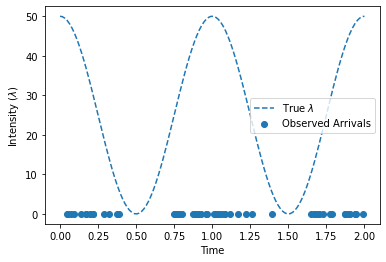

In [5]:
fig, ax = plt.subplots(1, 1)
ax.plot(times, true_intensity_function(times), "--", label=r"True $\lambda$")
ax.set_xlabel("Time")
ax.set_ylabel("Intensity ($\lambda$)")
ax.scatter(arrival_times, torch.zeros_like(arrival_times), label=r"Observed Arrivals")
ax.legend(loc="best")
None

In [6]:
class GPModel(gpytorch.models.ApproximateGP):
    def __init__(self, num_arrivals, max_time, num_inducing=32, name_prefix="cox_gp_model"):
        self.name_prefix = name_prefix
        self.max_time = max_time
        self.mean_intensity = (num_arrivals / max_time)

        # Define the variational distribution and strategy of the GP
        # We will initialize the inducing points to lie on a grid from 0 to T
        inducing_points = torch.linspace(0, max_time, num_inducing).unsqueeze(-1)
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(num_inducing_points=num_inducing)
        variational_strategy = gpytorch.variational.VariationalStrategy(self, inducing_points, variational_distribution)

        # Define model
        super().__init__(variational_strategy=variational_strategy)

        # Define mean and kernel
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, times):
        mean = self.mean_module(times)
        covar = self.covar_module(times)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

    def guide(self, arrival_times, quadrature_times):
        # Draw samples from q(f) at arrival_times
        # Also draw samples from q(f) at evenly-spaced points (quadrature_times)
        with pyro.plate(self.name_prefix + ".times_plate", dim=-1):
            pyro.sample(
                self.name_prefix + ".function_samples",
                self.pyro_guide(torch.cat([arrival_times, quadrature_times], -1))
            )

    def model(self, arrival_times, quadrature_times):
        pyro.module(self.name_prefix + ".gp", self)

        # Draw samples from p(f) at arrival times
        # Also draw samples from p(f) at evenly-spaced points (quadrature_times)
        with pyro.plate(self.name_prefix + ".times_plate", dim=-1):
            function_samples = pyro.sample(
                self.name_prefix + ".function_samples",
                self.pyro_model(torch.cat([arrival_times, quadrature_times], -1))
            )

        ####
        # Convert function samples into intensity samples, using the function above
        ####
        intensity_samples = function_samples.exp() * self.mean_intensity

        # Divide the intensity samples into arrival_intensity_samples and quadrature_intensity_samples
        arrival_intensity_samples, quadrature_intensity_samples = intensity_samples.split([
            arrival_times.size(-1), quadrature_times.size(-1)
        ], dim=-1)

        ####
        # Compute the log_likelihood, using the method described above
        ####
        arrival_log_intensities = arrival_intensity_samples.log().sum(dim=-1)
        est_num_arrivals = quadrature_intensity_samples.mean(dim=-1).mul(self.max_time)
        log_likelihood = arrival_log_intensities - est_num_arrivals
        pyro.factor(self.name_prefix + ".log_likelihood", log_likelihood)

In [7]:
model = GPModel(arrival_times.numel(), max_time)
quadrature_times = torch.linspace(0, max_time, 64)

In [8]:
import os
smoke_test = ('CI' in os.environ)
num_iter = 2 if smoke_test else 200
num_particles = 1 if smoke_test else 32


def train(lr=0.01):
    optimizer = pyro.optim.Adam({"lr": lr})
    loss = pyro.infer.Trace_ELBO(num_particles=num_particles,
                                 vectorize_particles=True,
                                 retain_graph=True)
    infer = pyro.infer.SVI(model.model,
                           model.guide,
                           optimizer,
                           loss=loss)

    model.train()
    loader = tqdm.notebook.tqdm(range(num_iter))
    for i in loader:
        loss = infer.step(arrival_times, quadrature_times)
        loader.set_postfix(loss=loss)

train()

  0%|          | 0/200 [00:00<?, ?it/s]

/home/alma/.local/lib/python3.7/site-packages/torch/autograd/__init__.py:147: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag
